In [1]:
import os
os.chdir("..")

In [2]:
import random
from tqdm import tqdm
from pathlib import Path
import numpy as np
import cv2
from joblib import Parallel, delayed, parallel_backend
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from multiprocessing.dummy import Pool
import pandas as pd

from skin_lesion_cad.data.BOVW import DenseDescriptor, BagofWords, ColorDescriptor
from skin_lesion_cad.features.colour import ColorFeaturesDescriptor

import matplotlib.pyplot as plt

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
SAMPLE_SIZE = 500
root_path = Path().resolve()

chall1 = root_path/"data/processed/chall1/train"
nevus_imgs = np.random.choice(list((chall1/'nevus').glob("*inpaint_0_5.png")), SAMPLE_SIZE)
others_imgs = np.random.choice(list((chall1/'others').glob("*inpaint_0_5.png")), SAMPLE_SIZE)
test_imgs = np.concatenate([nevus_imgs, others_imgs])

brisk = cv2.BRISK_create(thresh=30, octaves=0)


color_spaces = {'bgr':cv2.COLOR_RGB2BGR, 'hsv':cv2.COLOR_RGB2HSV, 'lab':cv2.COLOR_RGB2LAB,  'YCrCb':cv2.COLOR_RGB2YCrCb}
mshift_params = {'sp': 10, 'sr': 15} # spatial and color range radius


dense_brisk_color = ColorDescriptor(brisk, color_spaces, meanshift=mshift_params,
                              min_keypoints=100, max_keypoints=500,
                              kp_size=25)

dense_brisk = DenseDescriptor(descriptor=brisk, min_keypoints=100, max_keypoints=500, kp_size=10)


In [4]:
def _load_and_extract_des(x):
    image_path, descriptor = x
    im = cv2.imread(str(image_path))
    mask = cv2.imread(str(image_path).replace('inpaint', 'mask'))
    img_cls = 1 if 'nevus' in str(image_path) else 0
    kpts, des = descriptor.detectAndCompute(im, mask)
    return (des, img_cls)

descriptors = []
img_classes = []

with Pool(8) as pool:
    for (des, img_cls) in tqdm(pool.imap(_load_and_extract_des,
                                       zip(test_imgs,
                                           [dense_brisk]*len(test_imgs))), total=len(test_imgs)):
        descriptors.append(des)
        img_classes.append(img_cls)

100%|██████████| 1000/1000 [00:51<00:00, 19.59it/s]


In [5]:
descriptors_color = []
img_classes_color = []

with Pool(8) as pool:
    for (des, img_cls) in tqdm(pool.imap(_load_and_extract_des,
                                       zip(test_imgs,
                                           [dense_brisk_color]*len(test_imgs))), total=len(test_imgs)):
        descriptors_color.append(des)
        img_classes_color.append(img_cls)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
100%|██████████| 1000/1000 [09:18<00:00,  1.79it/s]


In [41]:
# # BRISK doesnt output a stable number of keypoints after .compute()
# _load_and_extract_des((test_imgs[10], dense_brisk))[0].shape

In [6]:
pd.to_pickle((descriptors_color, img_classes_color), 'descriptors_color.pkl')
pd.to_pickle((descriptors, img_classes), 'descriptors_brisk.pkl')
# descriptors, img_classes = pd.read_pickle('descriptors.pkl')

1000 100 64


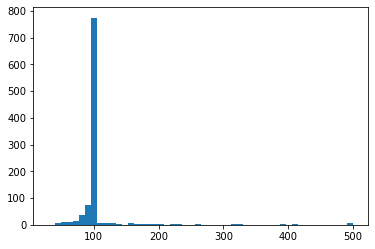

In [7]:
print(len(descriptors), len(descriptors_color[0]), len(descriptors[0][0]))
plt.hist([len(d) for d in descriptors], bins=50)
plt.show()

1000 100 96


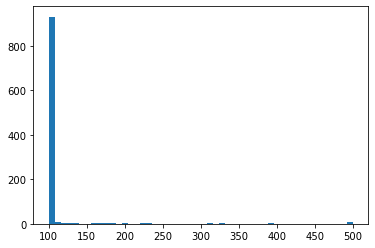

In [8]:
print(len(descriptors_color), len(descriptors_color[0]), len(descriptors_color[0][0]))
plt.hist([len(d) for d in descriptors_color], bins=50)
plt.show()

Brisk Dense

In [10]:
X_train, X_test, y_train, y_test = train_test_split(descriptors, img_classes, test_size=0.33, random_state=42)

bovw = BagofWords(n_words=100, n_jobs=-1, random_state=None)
classifier = SVC(max_iter=10000)

X_train_preprocessed = bovw.fit_transform(X_train,y_train) 
X_test_preprocessed = bovw.transform(X_test)

classifier.fit(X_train_preprocessed,y_train)
y_pred = classifier.predict(X_test_preprocessed)

print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'\nConfusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.67      0.72      0.69       165
           1       0.70      0.65      0.67       165

    accuracy                           0.68       330
   macro avg       0.69      0.68      0.68       330
weighted avg       0.69      0.68      0.68       330

Accuracy: 0.6848484848484848

Confusion Matrix: 
[[118  47]
 [ 57 108]]


Color descriptors

In [11]:
X_train, X_test, y_train, y_test = train_test_split(descriptors_color, img_classes_color, test_size=0.33, random_state=42)

bovw = BagofWords(n_words=100, n_jobs=-1, random_state=None)
classifier = SVC(max_iter=10000)

X_train_preprocessed = bovw.fit_transform(X_train,y_train) 
X_test_preprocessed = bovw.transform(X_test)

classifier.fit(X_train_preprocessed,y_train)
y_pred = classifier.predict(X_test_preprocessed)

print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'\nConfusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.73      0.70      0.72       165
           1       0.72      0.75      0.73       165

    accuracy                           0.72       330
   macro avg       0.72      0.72      0.72       330
weighted avg       0.72      0.72      0.72       330

Accuracy: 0.7242424242424242

Confusion Matrix: 
[[116  49]
 [ 42 123]]


Pure color features

In [19]:
proc_data = Path().resolve() / 'data/processed'
test_path = proc_data / f'{"chall1"}/{"train"}/{"meanshift"}'
feat_type = "meanshift"
nevus_data = pd.read_feather(test_path.parent / f'nevus_color_features_{feat_type}.feather').set_index('name')
nevus_data['class'] = 0
others_data = pd.read_feather(test_path.parent/ f'others_color_features_{feat_type}.feather').set_index('name')
others_data['class'] = 1
data = pd.concat([nevus_data, others_data])

current_test_data = data.loc[[str(x.name).split('_')[0] for x in test_imgs]]
current_test_data

,bgr_b_mean,bgr_b_std,bgr_b_skew,bgr_b_kurt,bgr_b_max,bgr_b_min,bgr_b_entrp,bgr_b_unq,bgr_g_mean,bgr_g_std,...,YCrCb_C_unq,YCrCb_r_mean,YCrCb_r_std,YCrCb_r_skew,YCrCb_r_kurt,YCrCb_r_max,YCrCb_r_min,YCrCb_r_entrp,YCrCb_r_unq,class
name,,,,,,,,,,,,,,,,,,,,,
nev01792,154.463104,19.443081,0.239615,-0.782060,215.0,118.0,9.099755,94.0,86.664337,19.309059,...,683.0,42.383915,2.928924,-0.653799,0.626598,48.751892,31.243637,9.105212,676.0,0
nev07050,105.512238,15.639775,0.139407,-0.672934,145.0,80.0,7.066496,64.0,67.908020,10.731828,...,136.0,17.142256,3.520540,0.195593,-0.811694,25.316565,10.619289,7.056373,136.0,0
nev03494,162.753403,20.151781,-1.532984,5.923489,194.0,27.0,11.081087,165.0,121.025276,18.942148,...,807.0,16.669722,2.432256,1.295335,5.754866,28.802084,4.479020,11.079269,807.0,0
nev02159,195.152145,8.464341,0.502303,-0.548105,221.0,180.0,8.954384,41.0,85.262360,14.322032,...,537.0,55.628731,3.425403,-1.290362,0.663560,59.458866,42.962429,8.953368,537.0,0
nev02889,165.830383,12.781013,0.650940,-0.436010,205.0,143.0,8.935997,63.0,88.841011,18.125711,...,325.0,38.839676,2.657823,-1.394471,1.317223,42.968636,27.646450,8.936501,325.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mel00247,137.070877,26.709900,0.256068,-0.347270,228.0,49.0,11.850394,178.0,94.676208,20.354094,...,6248.0,20.892353,9.754446,0.258069,-0.592843,52.993736,-4.203198,-inf,6248.0,1
mel01163,158.047577,8.677331,-0.589686,-0.136620,181.0,126.0,10.039591,53.0,94.779358,13.684340,...,1840.0,34.766911,3.610875,-0.195105,-0.487622,44.498768,23.149115,10.035662,1823.0,1
bkl00189,136.018799,11.708349,-0.539872,-0.059140,161.0,102.0,8.232908,60.0,89.860474,12.929121,...,495.0,20.880539,1.550249,-0.097506,0.191986,25.797655,15.104215,8.233915,495.0,1


In [20]:

all_X = current_test_data.drop(columns=['class']).values
all_y = current_test_data['class'].values


all_X[np.isnan(all_X)] = 0
all_X[np.isinf(all_X)] = 0

X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svc = SVC(kernel='rbf', probability=True)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

In [21]:
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'\nConfusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       150
           1       0.92      0.91      0.91       150

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300

Accuracy: 0.9133333333333333

Confusion Matrix: 
[[138  12]
 [ 14 136]]


Color features 100 words
```
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       164
           1       0.83      0.76      0.79       166

    accuracy                           0.80       330
   macro avg       0.81      0.80      0.80       330
weighted avg       0.81      0.80      0.80       330

Accuracy: 0.803030303030303

Confusion Matrix: 
[[139  25]
 [ 40 126]]
 ```

Pure BRISK on 1k images
```              
               precision    recall  f1-score   support

           0       0.72      0.64      0.68       165
           1       0.68      0.75      0.71       165

    accuracy                           0.70       330
   macro avg       0.70      0.70      0.70       330
weighted avg       0.70      0.70      0.70       330

Accuracy: 0.696969696969697

Confusion Matrix: 
[[106  59]
 [ 41 124]]
 ```